# First Floor
## Electricity demand analysis
Throughout this document hourly and daily electricity demand will be analised using different models and methods as seen in Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos (https://otexts.com/fpp2/). The two datasets comprise data for electricity demand observed from the entire first floor of a building, hourly data describe January 2019 while daily observations begin in 2017 and end in february 2019.

## Overview

The following tables contain all the models used and the accuracy achieved ordered by MAPE on the test set.

### Daily forecast

| Model                   | MAPE |
|-------------------------|------|
| STL + Random walk       |  1.5 |
| ARIMA(1, 0, 0)(1, 0, 0) |  2.6 |
| Dynamic regression      |  5.7 |
| ETS(A, N, A)            |  8.5 |

This time series is heavily influenced by seasonality:
- STL + random walk: decomposition for this series works extraordinarily well mainly because the seasonal adjusted component is substantially white noise, that is, best forecastable with randow walk;
- ARIMA(1, 0, 0)(1, 0, 0): being that seasonality is so important a model leveraging autocorrelation performs very well;
- Dynamic regression: regression works generally well for electricity demand, choosing the correct predictors may often be very hard;
- ETS(A, N, A): ets models don't go very well with heavily seasonal time series, even if the method employed takes seasonality into account.

### Hourly forecast

| Model                   | MAPE |
|-------------------------|------|
| MSTL + ARIMA(3, 1, 3)   |  3.9 |
| TBATS                   |  5.5 |
| Dynamic regression      |  5.9 |
| STL + ARIMA(2, 1, 2)    |  5.9 |
| ARIMA(2, 1, 0)(1, 1, 0) |  7.2 |
| ETS(M, N, A)            | 10.7 |

This time series is characterized by two seasonalities that both play a relevant role:
- MSTL + ARIMA(3, 1, 3): the best performing model is an ARIMA model trained on the seasonally adjusted component, considering both daily and weekly seasonality;
- TBATS: this model works well for time series with multiple seasonalities;
- Dynamic regression: regression can give very good results for electricity demand, in this case a research paper regressor is mimiced with acceptable accuracy;
- ARIMA(2, 1, 0)(1, 1, 0): it is generally hard to take into account multiple seasonalities with ARIMA, leaving some information outside of the forecast model;
- ETS(M, N, A): as previously stated ETS is not that well suited for electricity demand forecasting.

## Installing required packages

In [2]:
install.packages("hts")
install.packages("gridExtra")

Installing package into ‘/home/dpaletti/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)

also installing the dependencies ‘farver’, ‘labeling’, ‘munsell’, ‘R6’, ‘RColorBrewer’, ‘viridisLite’, ‘pkgconfig’, ‘xts’, ‘TTR’, ‘curl’, ‘gtable’, ‘isoband’, ‘scales’, ‘tibble’, ‘withr’, ‘quadprog’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘ggplot2’, ‘lmtest’, ‘magrittr’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘forecast’, ‘SparseM’, ‘matrixcalc’, ‘Rcpp’, ‘RcppEigen’




## Parsing
The first step in any analysis is parsing the data, in this case the datasets are written in CSV files where ";" is used as a separator and a header was manually added for easier parsing. Prior to any code block necessary libraries are imported.

In [1]:
library(ggplot2)    # graphics
library(GGally)     # extension for ggplot2
library(gridExtra)  # grid arrangement in plots
library(forecast)   # Hyndman package for time series analysis
library(urca)       # test facilities for differencing
library(httr)       # API interaction
library(rjson)      # json parsing
library(anytime)    # date manipulation facilities
library(timeDate)   # holiday manipulation

In [2]:
hourly <- read.csv(file = "./data/ed_hourly_first_january.csv", as.is=TRUE, sep=";", header= TRUE)
daily <- read.csv(file="./data/ed_daily_first.csv", as.is=TRUE, sep=";", header=TRUE)

hourly$date <- as.Date(hourly$date, format="%d/%m/%Y-%H")
daily$date <- as.Date(daily$date, format="%d/%m/%Y")

## Single seasonality time series definition and plotting
The basic facililty in forecast package for representing time series is the ts object, a time series object with one possible seasonality. In order to test the accuracy of the forecasting models the time series has to be split in training and test data, hourly data needs a 24 hour forecasting so a 24 hour test set will be created, daily data needs a one week forecasting so a one week test set will be created. 

In [3]:
daily.ts <- ts(daily$ed, frequency=7)
#> start=c(1, 1) 
#> end=c(103, 5)

hourly.ts <- ts(hourly$ed, frequency=24)
#> start=c(1, 1)
#> end=c(31, 24)

daily.train <- window(daily.ts, end=c(102, 5))
daily.test <- window(daily.ts, start=c(102, 5))

hourly.train <- window(hourly.ts, end=c(30, 24))
hourly.test <- window(hourly.ts, start=c(30, 24))

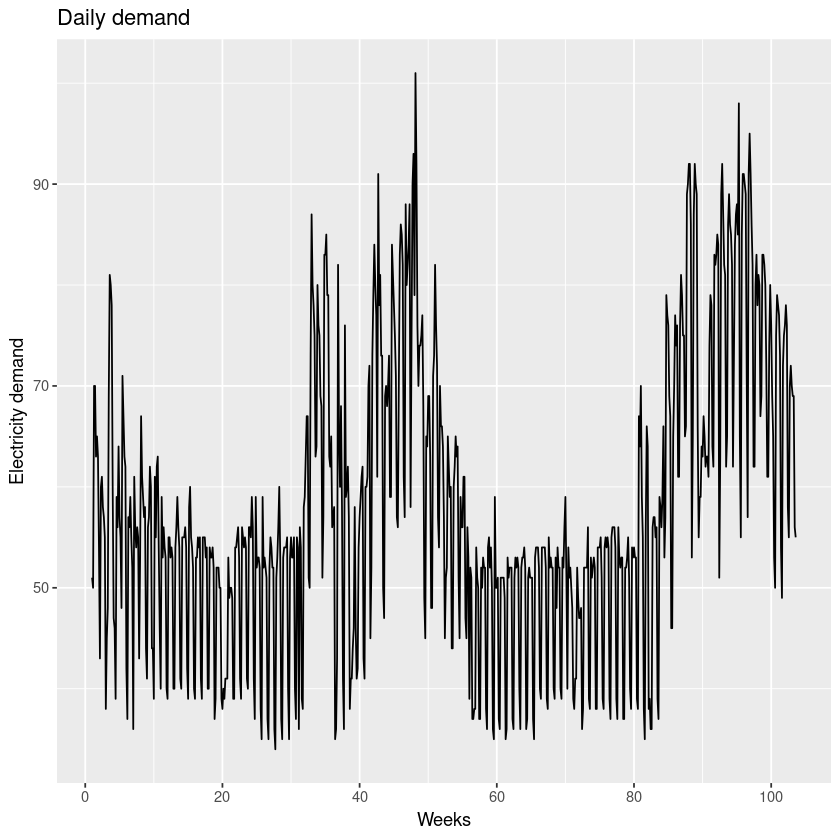

In [43]:
autoplot(daily.ts) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    ggtitle("Daily demand")

In the daily demand data a weekly seasonality is clearly present and the number of weeks is represented on the x-axis.The weekly seasonality is very strong but no other seasonality seems to be present, one would expect a yearly seasonality but the series is not long enough to spot it.

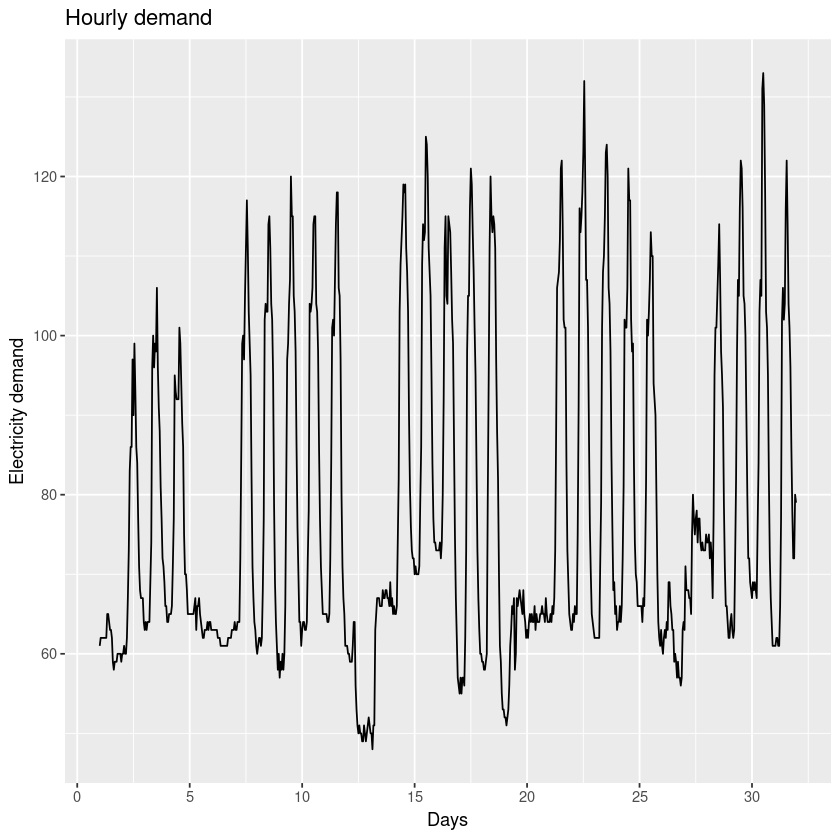

In [44]:
autoplot(hourly.ts) +
    xlab("Days") +
    ylab("Electricity demand") +
    ggtitle("Hourly demand")

This series is plotted with days on the x-axis to highlight the strong daily seasonality in the hourly data. Weekly seasonality seems to be clearly present too.

## Decomposition
The method chosen for time series decomposition is STL (Seasonal and trend decomposition using Loess) mainly because it handles any seasonality and not only quarterly or monthly, which the previous datasets do not show. Moreover STL can be robust to outliers so that they will not affect trend-cycle or seasonal component but only the remainder. The two main parameters to be chosen when usin STL decomposition are the trend-cycle window 't.window' and the seasonal window 's.window', that can be set to infinite with "periodic". When using mstl() s.window is set to 13 and t.window is automatically set.
In daily demand we see that the seasonal component does not change with trend and that the remainder does not contain much information, this means that probably the ts object leveraging only weekly seasonality correctly describes the dataset.
In hourly demand we see that seasonality is changing with time and that the remainder still contains a lot of information, this may point that another seasonality should be taken into account in order to have a complete description of the datasets

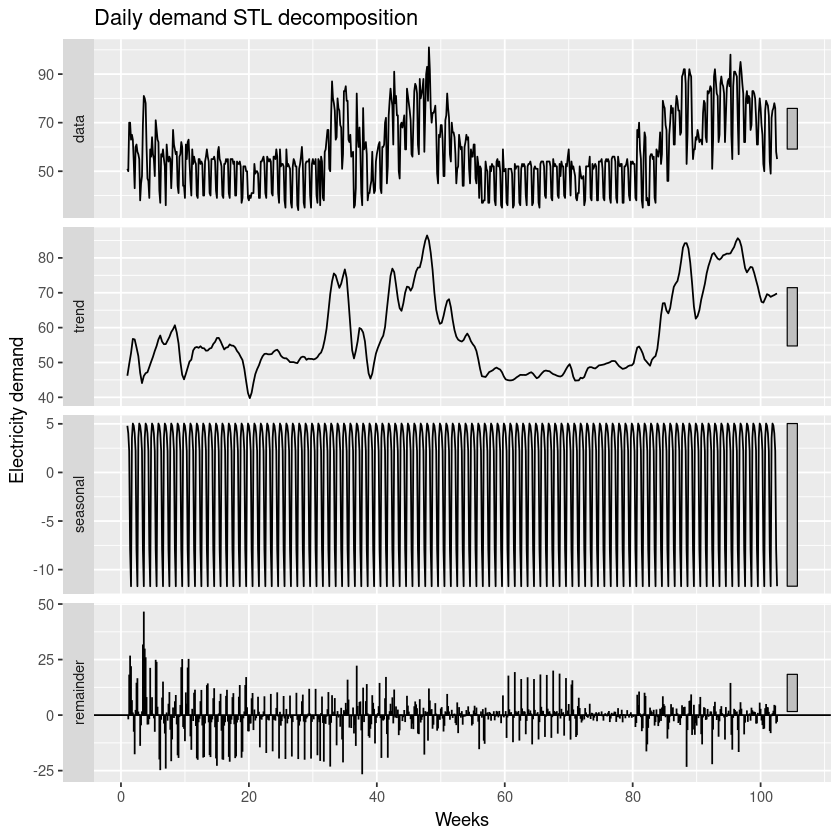

In [4]:
daily.train.stl <- stl(daily.train, t.window=13, s.window="periodic", robust=TRUE)
    autoplot(daily.train.stl) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    ggtitle("Daily demand STL decomposition")


As previously stated the weekly seasonality is clearly present and together with the trend component it seems to give a faithful representation of the time series given the low significance of the remainder component. The decomposition above altogether may tell that forecasting the components separately and then adding them back together may be a good strategy, later in the document tested.

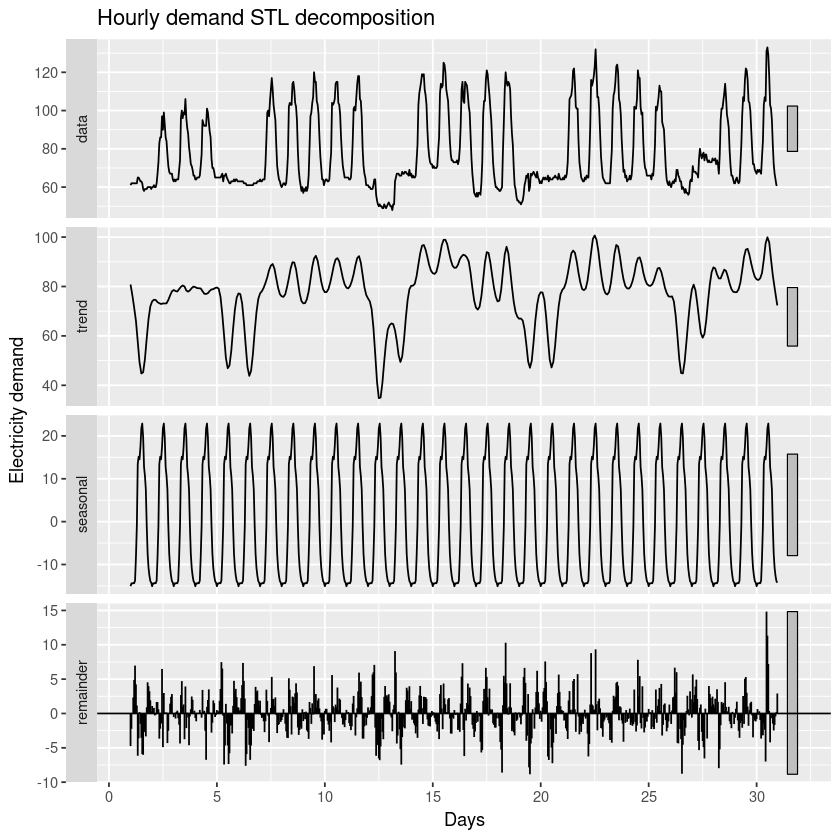

In [5]:
hourly.train.stl  <- stl(hourly.train, t.window=13, s.window="periodic")
    autoplot(hourly.train.stl) +
    xlab("Days") +
    ylab("Electricity demand") +
    ggtitle("Hourly demand STL decomposition")

The decomposition in this case highlights both the strength of the seasonality, in the third subplot, and the presence of another not yet considered property of the timeseries, another seasonality in the previously stated hypothesis, given the large amount of remainder represented in the fourth subplot. 

### Naive forecast of seasonally adjusted component and reseasonalization
One possible approach to forecasting is decomposing the time series in seasonally adjusted component, that is the time series without its seasonal component, and seasonal component, forecast those indipendently and then add the forecasts up to obtain the forecast for the chosen time series.
In general seasonal naive, or random walk, is used for the seasonal componal that is considered unchanging.
Naive: $$\hat{y}_{T + h | T} = y_T$$
Accuracy from now on will be calculated over the training and the test set using accuracy().

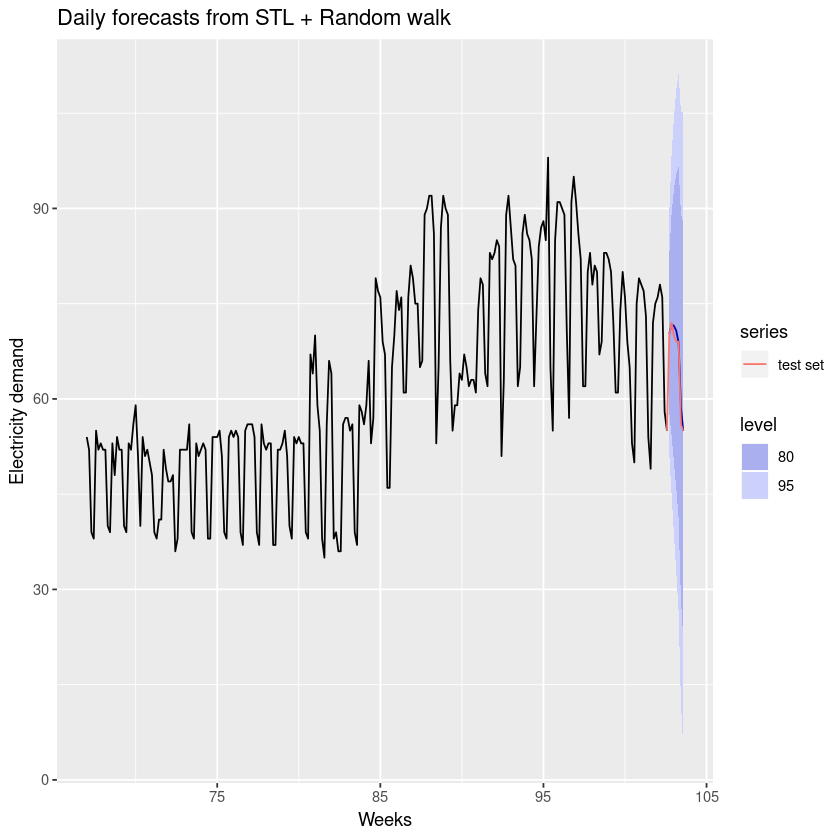

In [8]:
#daily
daily.fc.stl <- forecast(daily.train.stl,method="naive", h=7)
autoplot(daily.fc.stl, include = 250) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    autolayer(daily.test, series="test set") +
    ggtitle("Daily forecasts from STL + Random walk")

In [102]:
accuracy(daily.fc.stl, daily.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.02883818,9.676335,7.0158615,-1.282715,13.255322,1.1787851,-0.1261745,NA
Test set,-0.84585465,1.371815,0.9473851,-1.356956,1.499526,0.1591769,-0.4628869,0.2677625


As the STL decomposition showed almost all the information contained in the timeseries is employed when forecasting with decomposition in this case. The MAPE for the test set is very low showing an utterly good forecast. On the other hand there is a high MAPE on the train set that is partially due to the fact that the remainder for the first half of the series is more than the one for the second half and so the overall MAPE on the train set results bigger. The MAPE on the training set is far less significant then the one on the test set and so this can be considered an acceptable forecast.

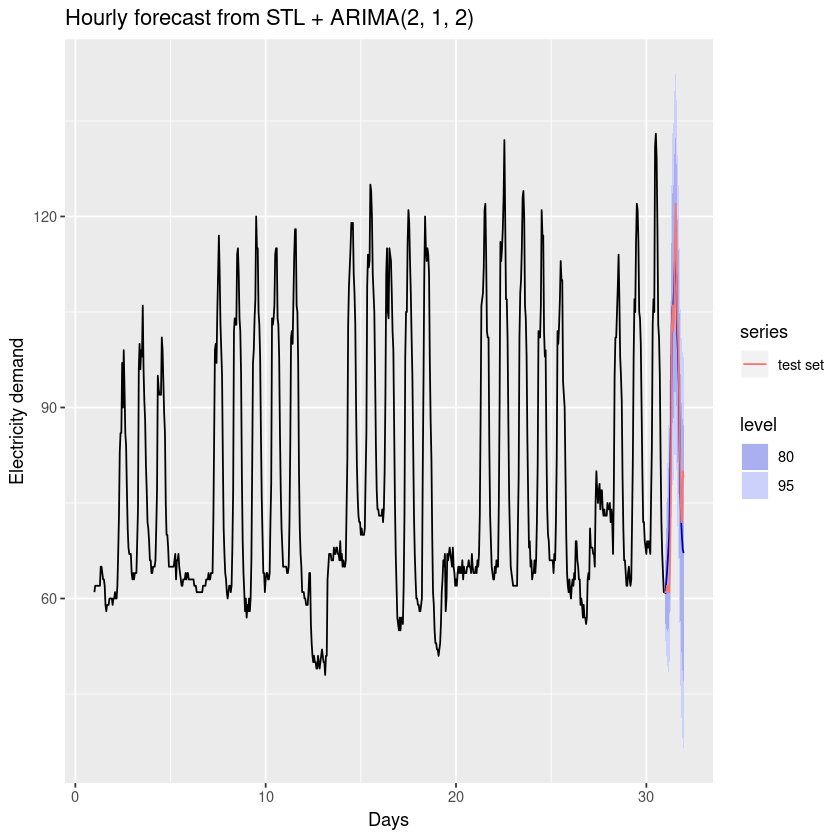

In [115]:
#hourly
hourly.fc.stl <- forecast(hourly.train.stl, method="arima", h=24)
autoplot(hourly.fc.stl) +
    xlab("Days") +
    ylab("Electricity demand") +
    autolayer(hourly.test, series="test set") +
    ggtitle("Hourly forecast from STL + ARIMA(2, 1, 2)")

In [114]:
accuracy(hourly.fc.stl, hourly.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.02642272,3.559461,2.498832,-0.08261507,3.222830,0.2522023,-0.01665069,NA
Test set,-0.05214002,6.057630,4.630034,-0.82004128,5.879577,0.4673004,0.71985486,0.9011639


## Exponential smoothing
Forecast made with exponential smoothing use a weighted average of past observation with weights decaying exponentially as observations get older. In order to forecast data with seasonality we must use an extension of the Simple exponential smoothing(SES) model, that cannot take into account neither seasonality nor trend, called Holt-Winter's method. 
In general the (T+1)-th osbservation in SES is $y_{T+1|T} = \alpha y_T + (1 - \alpha)\hat{y}_{T | T - 1}$.
SES can be described through a component form
\begin{align*}
  \text{Forecast equation}  && \hat{y}_{t+h|t} & = \ell_{t}\\
  \text{Smoothing equation} && \ell_{t}        & = \alpha y_{t} + (1 - \alpha)\ell_{t-1},
\end{align*}
Parameters $\alpha, l_0$ need to be estimated.  
SES is then extended to support trend, this is called Holt's method:
\begin{align*}
  \text{Forecast equation}&& \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} \\
  \text{Level equation}   && \ell_{t} &= \alpha y_{t} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  \text{Trend equation}   && b_{t}    &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 -\beta^*)b_{t-1},
\end{align*}
Then Holt-Winter's additive method is obtained by adding a seasonality equation:
\begin{align*}
  \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} + s_{t+h-m(k+1)} \\
  \ell_{t} &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
  s_{t} &= \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},
\end{align*}
Holt-Winter's method has multiplicative version too:
\begin{align*}
  \hat{y}_{t+h|t} &= (\ell_{t} + hb_{t})s_{t+h-m(k+1)} \\
  \ell_{t} &= \alpha \frac{y_{t}}{s_{t-m}} + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  b_{t} &= \beta^*(\ell_{t}-\ell_{t-1}) + (1 - \beta^*)b_{t-1}                \\
  s_{t} &= \gamma \frac{y_{t}}{(\ell_{t-1} + b_{t-1})} + (1 - \gamma)s_{t-m}
\end{align*}
In all the previous model it is possible to introduce a parameter for damping the trend, ES methods that take into account trend tend to overforcast because they extend trend infinitely into the future.
If we rearrange ETS model specification we get the error form:
\begin{align*}
\ell_{t} %&= \alpha y_{t}+\ell_{t-1}-\alpha\ell_{t-1}\\
         &= \ell_{t-1}+\alpha( y_{t}-\ell_{t-1})\\
         &= \ell_{t-1}+\alpha e_{t}
\end{align*}
If the error is written as a relative error we are talking about multiplicative error.
In general an exponential smoothing model is ETS(X, Y, Z) where:
- X can be either M, for multiplicative errors, or A, for additive errors, or N for no errors, so a point forecast.
- Y can be either none, additive, or additive damped (Ad), referring to trend estimation;
- Z for seasonality can be either, none, additive or multiplicative.  
The ets() function automatically chooses a model by minimising AIC (Aikake's information Criterion)

In [123]:
#daily
daily.fit.ets <- ets(daily.train, model="ZNZ") #trend is set to none while seasonality and errors
                                               #are calculated through AIC minimization

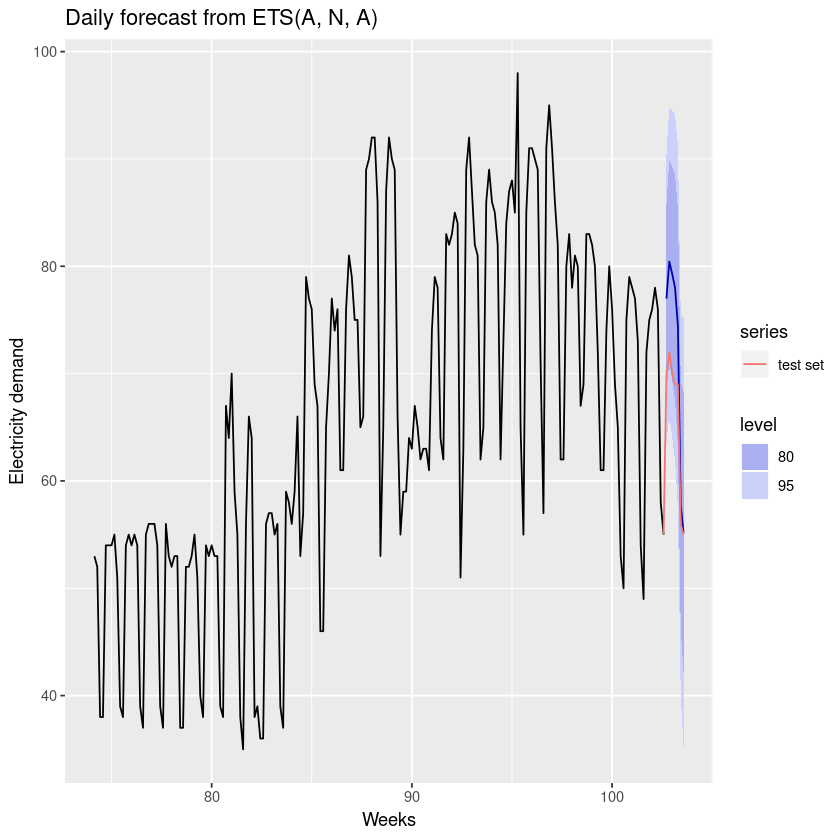

In [141]:
#daily
daily.fc.ets <- forecast(daily.fit.ets, h=7)
autoplot(daily.fc.ets, include = 200) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    autolayer(daily.test, series ="test set") +
    ggtitle("Daily forecast from ETS(A, N, A)")

In [131]:
#daily
accuracy(daily.fc.ets, daily.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.02962679,6.791037,4.714428,-0.935429,8.505955,0.7921049,0.2375264,NA
Test set,-5.86741012,6.765970,5.867410,-8.473911,8.473911,0.9858256,0.5862347,1.20538


Holt-Winter's method being an extension of the simple exponential smoothing and it is usually not the best model when taking into account data with strong autocorrelation and strong seasonality, MAPE for both test and training set is pretty high and this is not to be considered a good forecast.The plot also shows a very bad prediction for the first half of the test set probably because high weight is given to last observations that don't describe well the behaviour of the series in the test set, the model gives a prediction that is very similar to the last three weeks observation that, unfortunately, are not that similar to the observations in the test set.

In [138]:
#hourly
hourly.fit.ets <- ets(hourly.train, model="ZNZ")

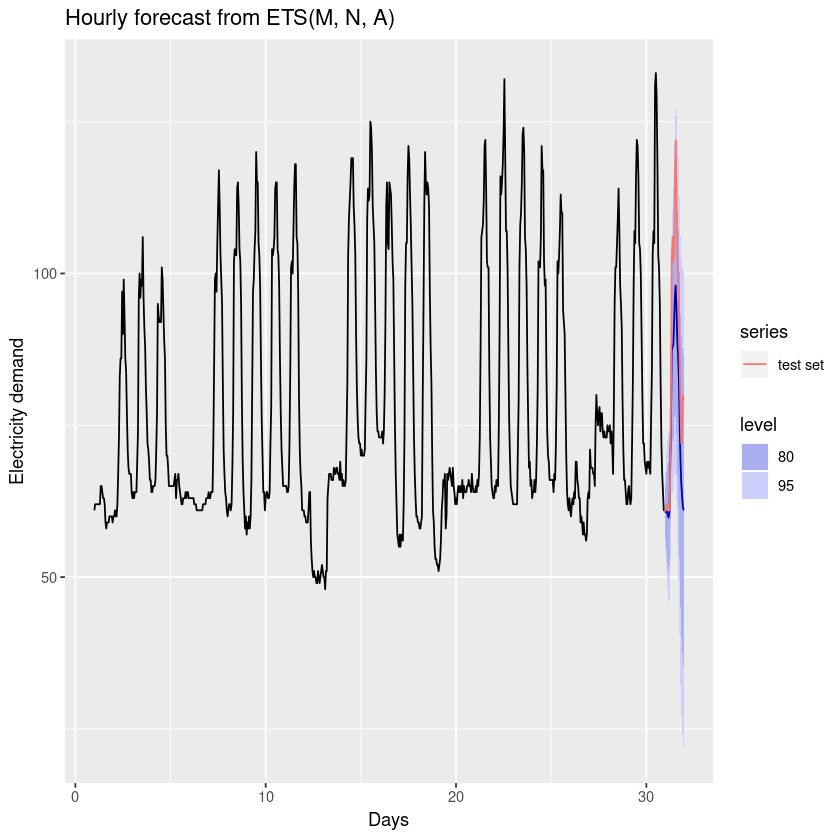

In [142]:
#hourly
hourly.fc.ets <- forecast(hourly.fit.ets, h=24)
autoplot(hourly.fc.ets) +
    xlab("Days") +
    ylab("Electricity demand") +
    autolayer(hourly.test, series ="test set") +
    ggtitle("Hourly forecast from ETS(M, N, A)")

In [143]:
#hourly
accuracy(hourly.fc.ets, hourly.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.004382162,4.020694,2.89295,-0.06162051,3.761301,0.2919798,0.2762354,NA
Test set,10.047153060,12.593044,10.16535,10.49755761,10.676728,1.0259692,0.7846088,1.401988


This prediction has a high MAPE on the test set because ets models are not well suited for series like those. In this case too much importance is given to the low values that the series exhibits during night hours, we can then see that the peak in electricity demand is greately underestimated whilst the general trend is not that distant from the real one. The peak underestimation is due to the high weights given by the ets model to near observations and the poor consideration given to autocorrellation.  

## Autoregressive integrated moving average (ARIMA)
In an autoregressive model we forecast future observation using a linear combination of past observations, an autoregressive model of order p AR(p) can be written as $$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$$
that is like a multiple regression model but with lagged values of y. Usually AR models are restricted to stationary, non trending nor seasonal, timeseries. Moving average models MA(q) rather than using past observations use past errors in a linear combination $$y_{t} = c + \varepsilon_t + \theta_{1}\varepsilon_{t-1} + \theta_{2}\varepsilon_{t-2} + \dots + \theta_{q}\varepsilon_{t-q}$$
By combining AR and MA we obtain a non seasonal ARIMA model
$$y'_{t} = c + \phi_{1}y'_{t-1} + \cdots + \phi_{p}y'_{t-p} + \theta_{1}\varepsilon_{t-1} + \cdots + \theta_{q}\varepsilon_{t-q} + \varepsilon_{t}$$
where $y'_t$ is the differenced series, that is $y'_t = y_t - y_{t - 1}$ for degree one first differencing . The previous model is called an ARIMA(p,d, q) model where p is the order of AR, d is the order of first differencing and q is the order of MA.  
As a first step an autocorrelation and partial autocorrelation plot is useful for understanding which kind of ARIMA model one needs. Autocorrelation indicates the correlation between an observation and the ones before, partial autocorrelation removes the effect of the previous observation from the calculation.
Both hourly and daily data show seasonality so an ARIMA seasonal model needs to be used where (p, d, q) are the same of a non seasonal model and (P, D, Q)m are introduced for the seasonal part of the model, where m is the number of observations per year. The seasonal part of the model is similar to the non seasonal part but includes backshifting of the seasonal period

In [19]:
#daily
daily.fit.arima <- Arima(daily.train, order = c(1, 0, 0), seasonal = c(1, 0, 0)) 

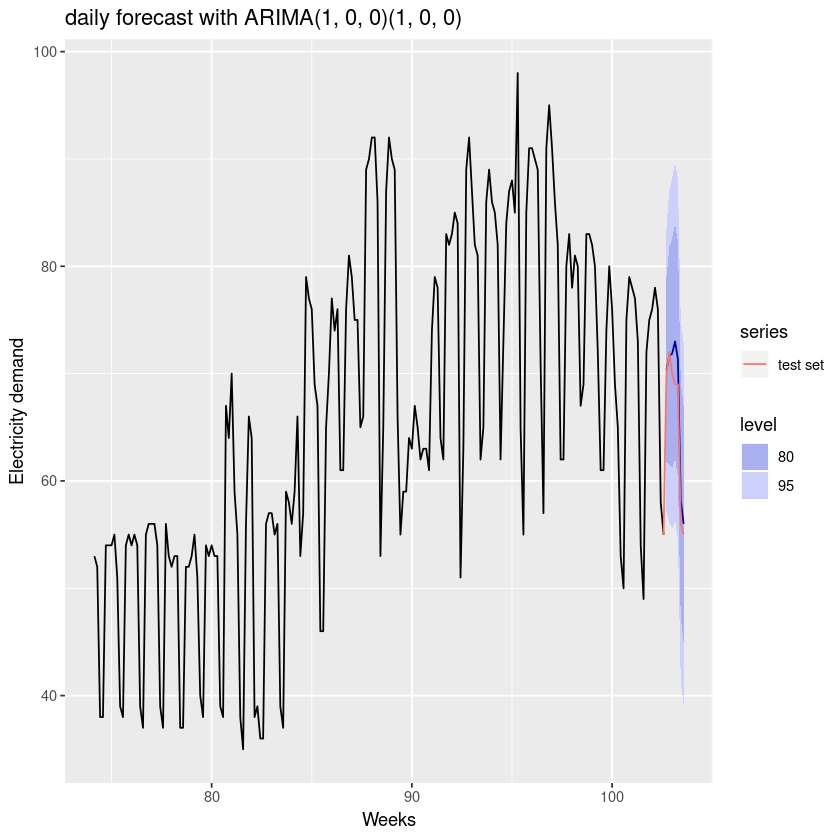

In [20]:
#daily
daily.fc.arima <- forecast(daily.fit.arima, h=7)
autoplot(daily.fc.arima, include=200) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    autolayer(daily.test, series="test set") +
    ggtitle("daily forecast with ARIMA(1, 0, 0)(1, 0, 0)")

In [21]:
#daily
accuracy(daily.fc.arima, daily.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.0008084316,6.699660,4.724109,-1.476314,8.511817,0.7937315,-0.04817145,NA
Test set,-1.6273348221,2.109388,1.726410,-2.514659,2.652264,0.2900666,0.35521342,0.4149204


ARIMA leverages autocorrelation in the model hence it works well with electricity demand time series that show strong autocorrelation:

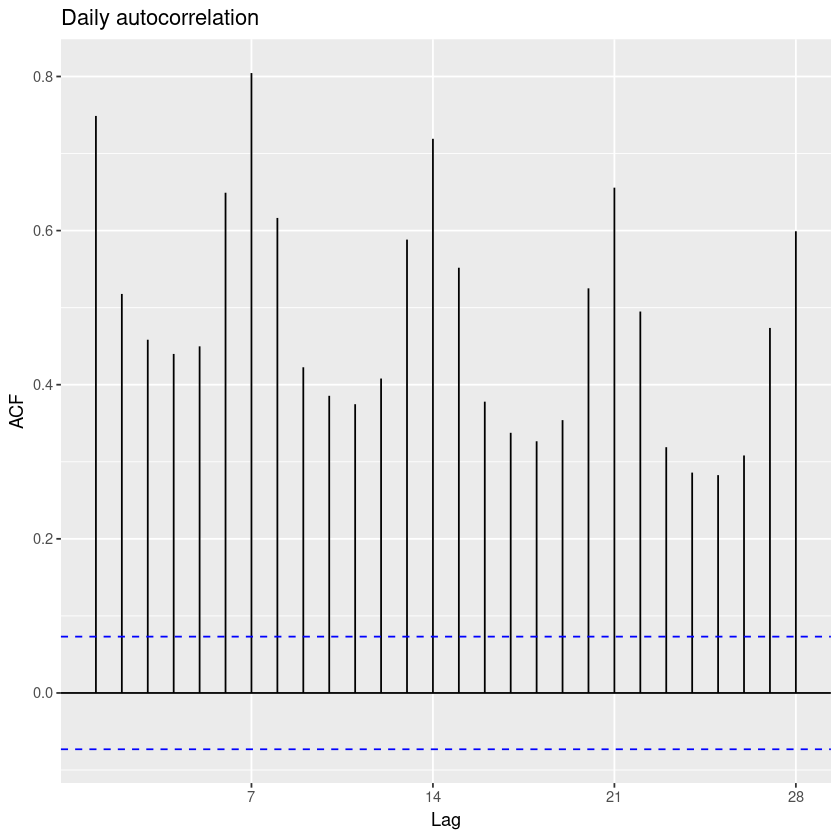

In [25]:
ggAcf(daily.ts) +
ggtitle("Daily autocorrelation")

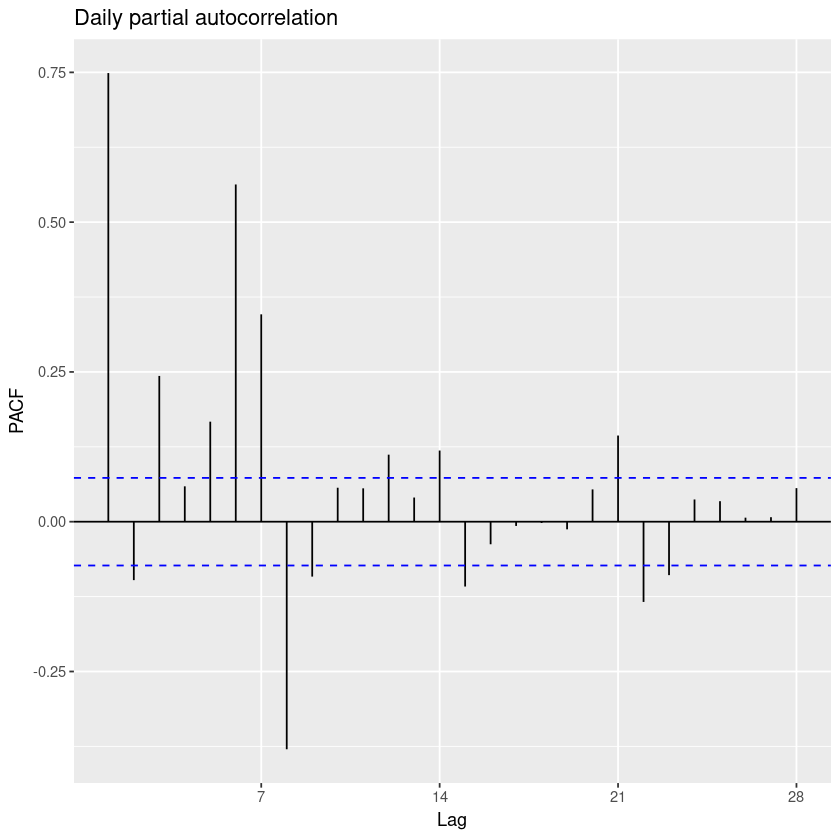

In [27]:
ggPacf(daily.ts) +
    ggtitle("Daily partial autocorrelation")

The only components taken into consideration are the autoregressive components, the one so important for this series, in particular 1 is chosen because the partial autocorrelation shows a significantly high spike, the seasonal component is replicated from the non seasonal one for convenience. Obviously an a posteriori analysis has been conducted on those parameters, some educated guessing has driven the experimentation part then the meaning of those parameters has been inspected to understand why they worked so well.

In [89]:
#hourly
hourly.fit.arima <- Arima(hourly.train, order=c(2, 1, 0), seasonal=c(1, 1, 0))

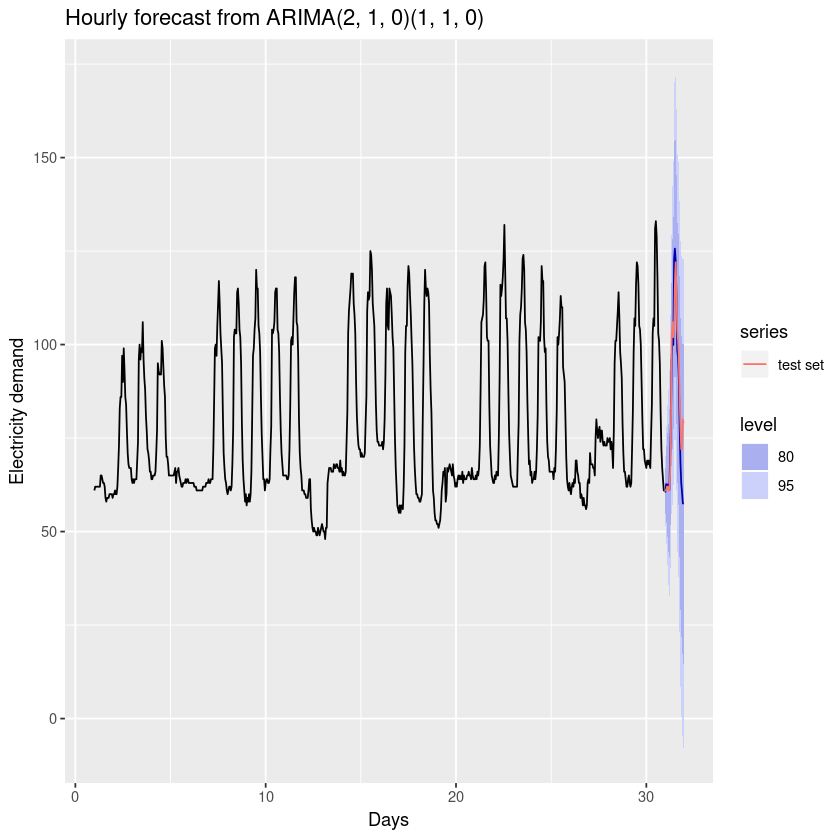

In [93]:
#hourly
hourly.fc.arima<- forecast(hourly.fit.arima, h=24)
autoplot(hourly.fc.arima) +
    xlab("Days") +
    ylab("Electricity demand") +
    autolayer(hourly.test, series="test set") +
    ggtitle("Hourly forecast from ARIMA(2, 1, 0)(1, 1, 0)")

In [92]:
#hourly
accuracy(hourly.fc.arima, hourly.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.003775403,4.306289,2.935244,0.00512924,3.755696,0.2962485,-0.01237697,NA
Test set,3.011438952,8.957360,6.145590,3.86176280,7.205703,0.6202626,0.64836250,1.164787


In [23]:
ur.kpss(diff(hourly.ts))


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.0058 


In [30]:
ur.kpss(hourly.ts)


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.3575 


The KPSS unit root test shows how first order differencing heavily affects the test statistic so an ARIMA (p, 1, q) is chosen.

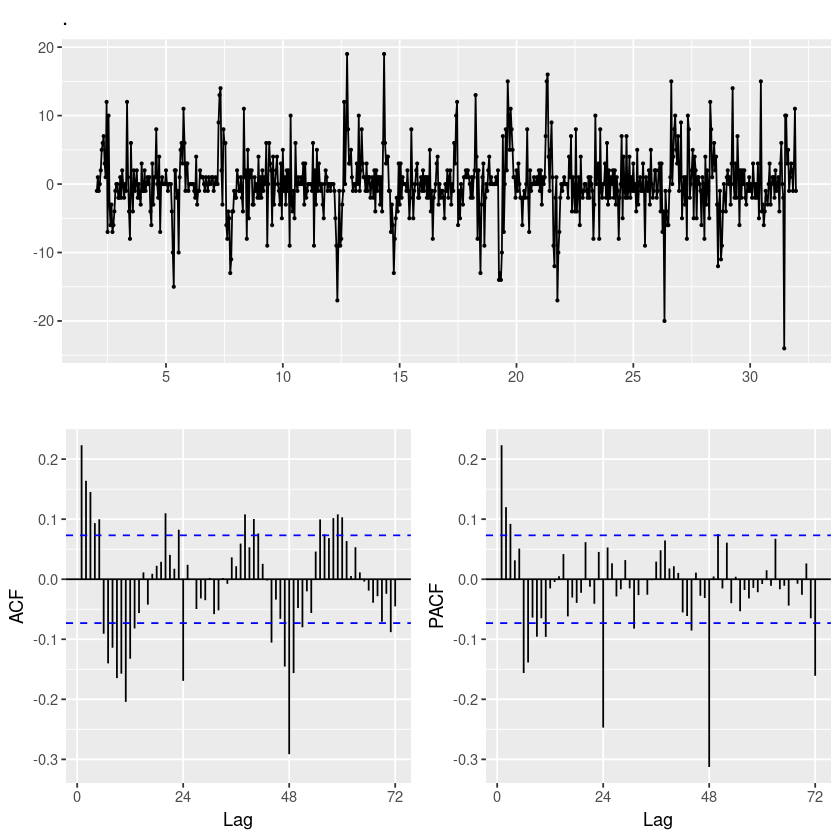

In [41]:
diff(diff(hourly.ts), lag=24) %>% ggtsdisplay()

In order to have a plot of the residuals that looks like white noise it is important to difference on daily seasonality, that is, use an ARIMA(p, 1, q)(ps, 1, qs). ACF and PACF don't give much information and so some parameter tweaking is needed, in those cases the auto.arima() function may help out but in this case it performs pretty poorly.

## Complex seasonality
High frequency time series often show multiple seasonality. As shown in the STL decomposition the hourly dataset is not fully described with a daily seasonality and so the use of multiple seasonality models involving weekly seasonality along daily seasonality is expected to be beneficial to forecast accuracy. The daily dataset would probably show a yearly seasonality if it were a longer series but two seasons are not enough to leverage seasonality.

In [36]:
hourly.msts <- msts(hourly$ed, seasonal.periods = c(24, 168))
#> start=c(1, 1)
#> end=c(5, 72) (4 settimane e tre giorni)
hourly.msts.train <- window(hourly.msts, end=c(5, 48))
hourly.msts.test <- window(hourly.msts, start=c(5, 48))

### STL decomposition
The mstl() function is a variation on the stl() function to deal with multiple seasonality, it shows all the seasonal components in one go. The plot shows a less significant remainder component as expected.

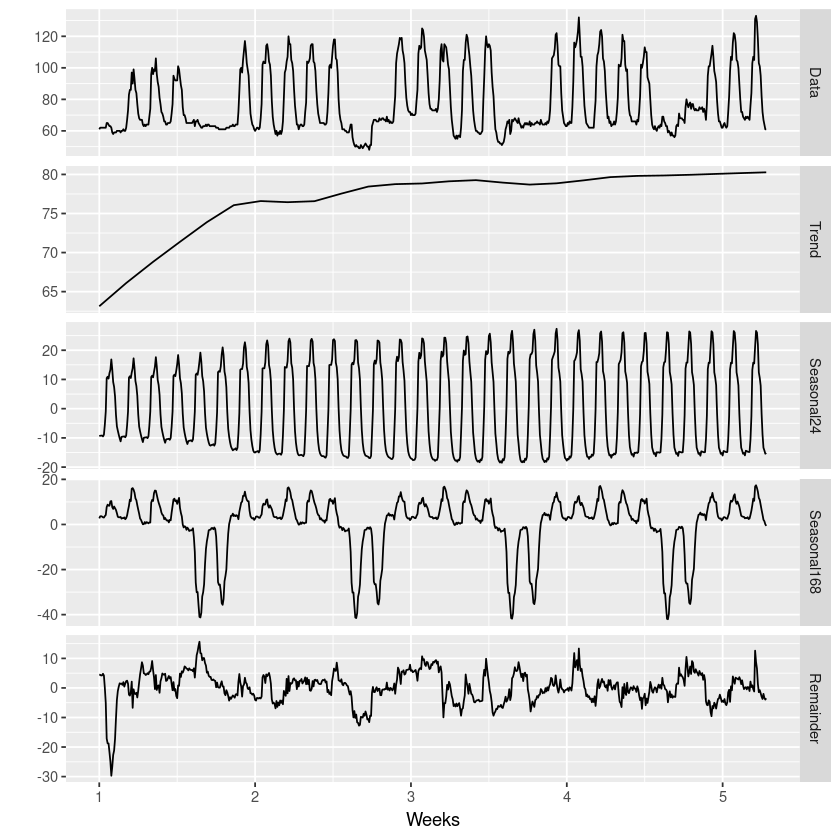

In [37]:
hourly.msts.train.mstl <- mstl(hourly.msts.train)
autoplot(hourly.msts.train.mstl) +
    xlab("Weeks")

### Forecasting with decomposition
The stlf() function allows easy forecasting for a decomposed series, a seasonal naive method is applied to the seasonal components and the seasonally adjusted data is forecasted with a user specified method, in this case an ARIMA model.

In [51]:
hourly.msts.fc.stlf <- stlf(hourly.msts.train, h=24, method="arima")

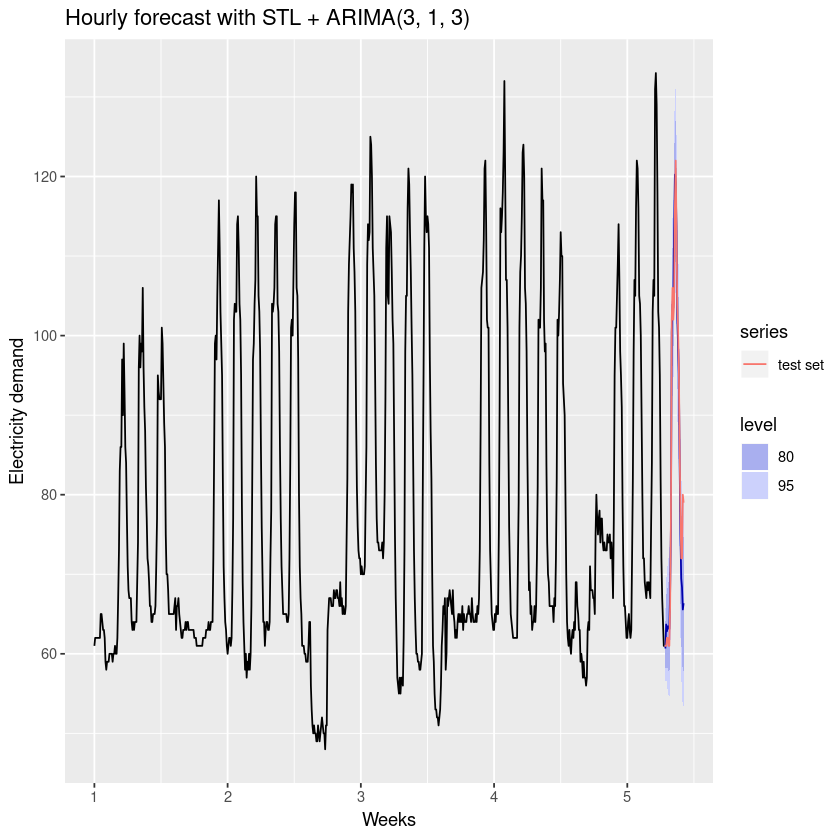

In [52]:
autoplot(hourly.msts.fc.stlf) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    autolayer(hourly.msts.test, series="test set") +
    ggtitle("Hourly forecast with STL + ARIMA(3, 1, 3)")

In [53]:
accuracy(hourly.msts.fc.stlf, hourly.msts.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.1297846,2.199106,1.568038,0.1138245,2.004327,0.2064783,-0.005916153,NA
Test set,1.0473335,4.799840,3.225408,1.2283111,3.905599,0.4247198,0.584635111,0.6466109


This model gives very good results as it takes into consideration both the weekly and the daily seasonality of the time series, the prediction intervals are very narrow and both training and test set MAPEs are very low.

### TBATS
A TBATS model uses a combination of Fourier terms, BoxCox transformation and exponential smoothing in a completely automated manner. In TBATS models the seasonality is allowed to slightly change overtime.

In [74]:
hourly.msts.fit.tbats <- tbats(hourly.msts.train, use.arma.errors = TRUE)

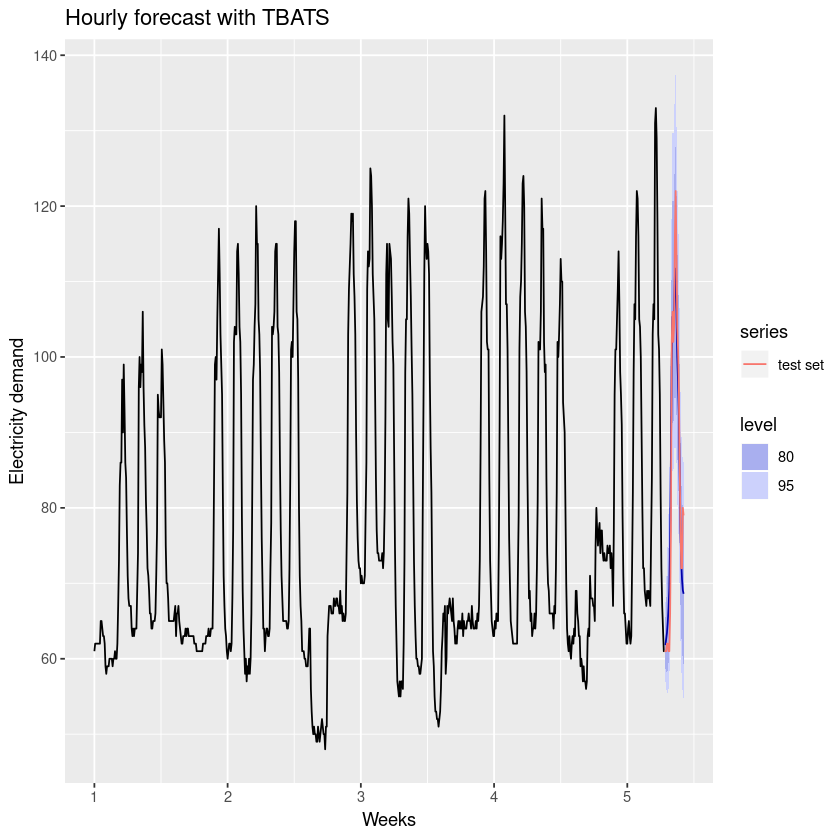

In [75]:
hourly.msts.fc.tbats <- forecast(hourly.msts.fit.tbats, h=24)
autoplot(hourly.msts.fc.tbats) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    autolayer(hourly.msts.test, series="test set") +
    ggtitle("Hourly forecast with TBATS")

In [76]:
accuracy(hourly.msts.fc.tbats, hourly.msts.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.1257579,3.374719,2.390945,0.009993641,3.024317,0.3148382,-0.08980519,NA
Test set,0.7070459,5.741165,4.496772,-0.061759403,5.488989,0.5921322,0.69067372,0.8042394


This model gives pretty good results but it is hard to tweak because many parameters are automatically selected and so, as with any automated model, it is hard to get excellent results but, in any case, the prediction intervals are narrow and both MAPEs are not so high.

## Dynamic regression models
Dynamic regression models allow including additional information like holidays and temperatures while still considering autocorrelation the same way ARIMA models do. In general the error term $\eta_t$ is calculated through an ARIMA model so we have a linear regression model like 
$$y_t = \beta_0 + \beta_1 x_{1,t} + \dots + \beta_k x_{k,t} + \eta_t,$$
and, for example, if $eta_t$ follows an ARIMA(1, 1, 1) model
$$(1-\phi_1B)(1-B)\eta_t = (1+\theta_1B)\varepsilon_t$$
where $\varepsilon_t$ is a white noise series, that is the ARIMA model error.
Temperatures will be used as external predictors, data is downloaded from DarkSky.net . The prediction for electricity demand is to be done for a building in Bergamo, Italy.

### Hourly data
Predictors choiche is based on https://robjhyndman.com/publications/stlf/.  
Chosen predictors:¶
- electricity demand a hour before
- electricity demand a day before
- electricity demand 2 days before
- maximum demand in the last 24 hours
- minimum demand in the last 24 hours
- average demand in the last 7 days
- temperature from a hour before
- maximum temperature in the last 24 hours
- minimum temperature in the last 24 hours
- average temperature in the last 7 days
- day of the week  
The code for API querying has been disabled because the data has been stored on a CSV file.

In [10]:
hourly.temperature <- read.csv(file = "./dati_forecasting/hourly_temperature.csv", as.is=TRUE, sep=",", header= TRUE)
hourly.temperature.ts <- ts(temperature$temperature, frequency=24)
hourly.temperature.train <- window(hourly.temperature.ts, end=c(30, 24))

In [11]:
#lag function
custom_lag <- function(x, k){
    y <- vector()
    y[seq(k)] <- 0
    for(j in seq(from=k+1, to=length(x)))
        y[j] <- x[j-k]
     y <- ts(y, frequency=frequency(x))
    return(y)
}


#demand

#one hour lag
hourly.train.lag1 <- custom_lag(hourly.train, 1)

#one day lag
hourly.train.lag24 <- custom_lag(hourly.train, 24)

#two days lag
hourly.train.lag48 <- custom_lag(hourly.train, 48)

#maximum demand
hourly.train.max <- vector()
for(j in seq(hourly.train))
    hourly.train.max[j] <- max(hourly.train[seq(from=max(1, j - 24), to=j)])

#minimum demand
hourly.train.min <- vector()
for(j in seq(hourly.train))
    hourly.train.min[j] <- min(hourly.train[seq(from=max(1, j - 24), to=j)])

#mean demand
hourly.train.mean <- vector()
for(j in seq(hourly.train))
    hourly.train.mean[j] <- mean(hourly.train[seq(from=max(1, j - 24), to=j)])


#temperature

#one hour lag
hourly.temperature.train.lag1 <- custom_lag(hourly.temperature.train, 1)

#current temperature differential
hourly.temperature.train.diff <- vector()
hourly.temperature.train.diff[1] <- hourly.temperature.train[2]- hourly.temperature.train[1]
for(j in seq(from=2, to=length(hourly.temperature.train)))
    hourly.temperature.train.diff[j] <- hourly.temperature.train[j] - hourly.temperature.train[j - 1]

#maximum temperature for the last 24 hours
hourly.temperature.train.max <- vector()
for(j in seq(hourly.temperature.train))
    hourly.temperature.train.max[j] <- max(hourly.temperature.train[seq(from=max(1, j - 24), to=j)])

#minimum temperature for the last 24 hours
hourly.temperature.train.min <- vector()
for(j in seq(hourly.temperature.train))
    hourly.temperature.train.min[j] <- min(hourly.temperature.train[seq(from=max(1, j - 24), to=j)])

#average temperature for the last week
hourly.temperature.train.mean <- vector()
for(j in seq(hourly.temperature.train))
    hourly.temperature.train.mean[j] <- mean(hourly.temperature.train[seq(from=max(1, j - (24 * 7)), to=j)])

#day of the week predictors
monday <- vector()
tuesday <- vector()
wednesday <- vector()
thursday <- vector()
friday <- vector()
saturday <- vector()
for(j in seq(hourly.train)){
    monday[j] <- 0
    tuesday[j] <- 0
    wednesday[j] <- 0
    thursday[j] <- 0
    friday[j] <- 0
    saturday[j] <- 0
    if(format(hourly$date[j], "%A") == "Monday")
        monday[j] <- 1
    if(format(hourly$date[j], "%A") == "Tuesday")
        tuesday[j] <- 1
    if(format(hourly$date[j], "%A") == "Wednesday")
        wednesday[j] <- 1
    if(format(hourly$date[j], "%A") == "Thursday")
        thursday[j] <- 1
    if(format(hourly$date[j], "%A") == "Friday")
        friday[j] <- 1
    if(format(hourly$date[j], "%A") == "Saturday")
        saturday[j] <- 1
}

In [12]:
#model fitting
xreg <- cbind(hourly.train.lag1 = hourly.train.lag1,
              hourly.train.lag24 = hourly.train.lag24,
              hourly.train.lag48 = hourly.train.lag48,
              hourly.train.max = hourly.train.max,
              hourly.train.min = hourly.train.min,
              hourly.train.mean = hourly.train.mean,
              hourly.temperature.train.diff = hourly.temperature.train.diff,
              hourly.temperature.train.lag1 = hourly.temperature.train.lag1,
              hourly.temperature.train.max = hourly.temperature.train.max,
              hourly.temperature.train.min = hourly.temperature.train.min,
              hourly.temperature.train.mean = hourly.temperature.train.mean,
              monday = monday,
              tuesday = tuesday,
              wednesday = wednesday,
              thursday = thursday,
              friday = friday,
              saturday = saturday)
hourly.fit.reg <- auto.arima(hourly.train, xreg=xreg)

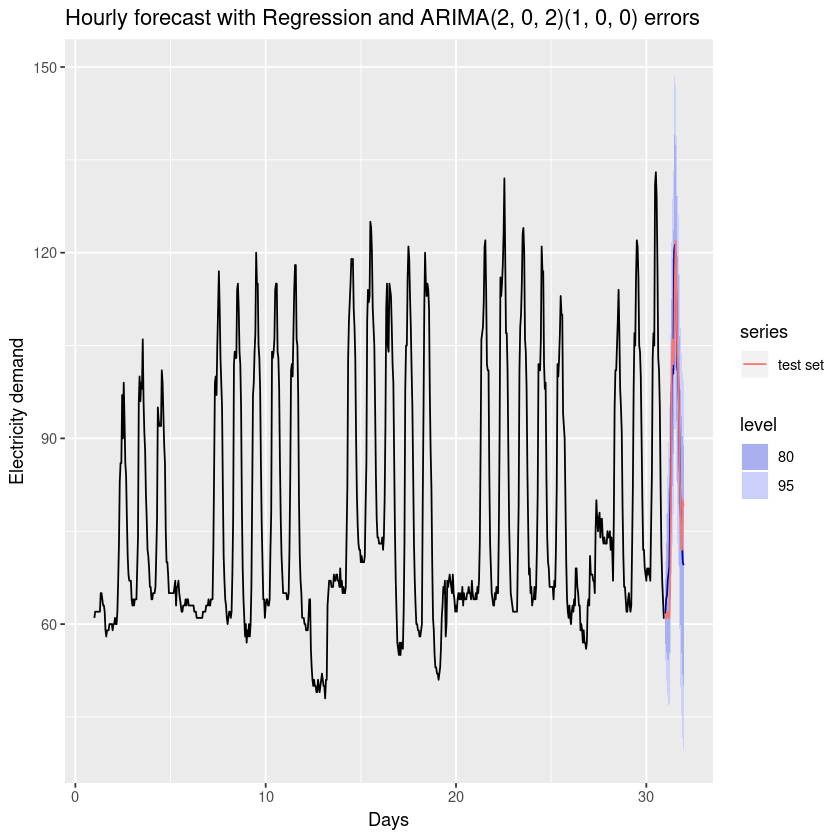

In [17]:
hourly.fc.reg <- forecast(hourly.fit.reg, xreg=tail(xreg, 24))
autoplot(hourly.fc.reg) +
    xlab("Days") +
    ylab("Electricity demand") +
    autolayer(hourly.test, series="test set") +
    ggtitle("Hourly forecast with Regression and ARIMA(2, 0, 2)(1, 0, 0) errors")

In [14]:
accuracy(hourly.fc.reg, hourly.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.02250173,3.654036,2.591042,-0.04462673,3.292261,0.2615088,-0.004908843,NA
Test set,-1.45702413,6.183687,4.659134,-2.38842675,5.894321,0.4702375,0.453701903,0.8751845


Many predictors have been used in this case, the time for estimating such models can be pretty long and even the time for building such models can be longer than for other more standardized model. All in all the results are not bad, and probably regression models are the ones that for electricity demand prediction have the most room for improvement.

### Daily Data

A research paper for daily electricity demand in South Africa (https://mafiadoc.com/daily-electricity-demand-forecasting-in-south-africa-academic-journals_5b251d6e097c47b24c8b4585.html) is used as a guide for choosing predictors.
Chosen predictors:
- month (dummy variable)
- day of the week (dummy variable)
- holiday , day after and before any holiday (dummy variable)
- trend

In [79]:
#dummy variables

#day of the week predictors
daily.monday <- vector()
daily.monday[seq(daily.train)] <- 0
daily.monday[format(daily$date[seq(daily.train)], "%A") == "Monday"] <- 1

daily.tuesday <- vector()
daily.tuesday[seq(daily.train)] <- 0
daily.tuesday[format(daily$date[seq(daily.train)], "%A") == "Tuesday"] <- 1

daily.wednesday <- vector()
daily.wednesday[seq(daily.train)] <- 0
daily.wednesday[format(daily$date[seq(daily.train)], "%A") == "Wednesday"] <- 1

daily.thursday <- vector()
daily.thursday[seq(daily.train)] <- 0
daily.thursday[format(daily$date[seq(daily.train)], "%A") == "Thursday"] <- 1

daily.friday <- vector()
daily.friday[seq(daily.train)] <- 0
daily.friday[format(daily$date[seq(daily.train)], "%A") == "Friday"] <- 1

daily.saturday <- vector()
daily.saturday[seq(daily.train)] <- 0
daily.saturday[format(daily$date[seq(daily.train)], "%A") == "Saturday"] <- 1

#month predictors
daily.january <- vector()
daily.january[seq(daily.train)] <- 0
daily.january[format(daily$date[seq(daily.train)], "%B") == "January"] <- 1

daily.february <- vector()
daily.february[seq(daily.train)] <- 0
daily.february[format(daily$date[seq(daily.train)], "%B") == "February"] <- 1

daily.march <- vector()
daily.march[seq(daily.train)] <- 0
daily.march[format(daily$date[seq(daily.train)], "%B") == "March"] <- 1

daily.april <- vector()
daily.april[seq(daily.train)] <- 0
daily.april[format(daily$date[seq(daily.train)], "%B") == "April"] <- 1

daily.may <- vector()
daily.may[seq(daily.train)] <- 0
daily.may[format(daily$date[seq(daily.train)], "%B") == "May"] <- 1

daily.june <- vector()
daily.june[seq(daily.train)] <- 0
daily.june[format(daily$date[seq(daily.train)], "%B") == "June"] <- 1

daily.july <- vector()
daily.july[seq(daily.train)] <- 0
daily.july[format(daily$date[seq(daily.train)], "%B") == "July"] <- 1

daily.august <- vector()
daily.august[seq(daily.train)] <- 0
daily.august[format(daily$date[seq(daily.train)], "%B") == "August"] <- 1

daily.september <- vector()
daily.september[seq(daily.train)] <- 0
daily.september[format(daily$date[seq(daily.train)], "%B") == "September"] <- 1

daily.october <- vector()
daily.october[seq(daily.train)] <- 0
daily.october[format(daily$date[seq(daily.train)], "%B") == "October"] <- 1

daily.november <- vector()
daily.november[seq(daily.train)] <- 0
daily.november[format(daily$date[seq(daily.train)], "%B") == "November"] <- 1

#holiday
daily.demand_holiday <- vector()
daily.demand_holiday[seq(daily.train)] <- 0
daily.demand_holiday[isHoliday(as.timeDate(daily$date[seq(daily.train)]), holidays = holidayNYSE(2017))] <- 1

#day before holiday
daily.demand_holiday_early <- vector()
daily.demand_holiday_early[seq(daily.train)] <- 0
for(j in seq(from=1, to=(length(daily.train) - 1))){
    daily.demand_holiday_early[j] <- daily.demand_holiday[j + 1]
}

#day after holiday
daily.demand_holiday_late <- vector()
daily.demand_holiday_late[seq(daily.train)] <- 0
for(j in seq(from=2, to=(length(daily.train) + 1))){
    daily.demand_holiday_late[j] <- daily.demand_holiday[j - 1]
}

In [82]:
xreg <- cbind(daily.demand_holiday,
              daily.demand_holiday_early,
              daily.demand_holiday_late,
              daily.january,
              daily.february,
              daily.march,
              daily.april,
              daily.may,
              daily.june,
              daily.july,
              daily.august,
              daily.september,
              daily.october,
              daily.november,
              daily.monday,
              daily.tuesday,
              daily.wednesday,
              daily.thursday,
              daily.friday,
              daily.saturday,
              trendcycle(daily.train.stl))
daily.fit.reg <- auto.arima(daily.train, xreg=xreg)

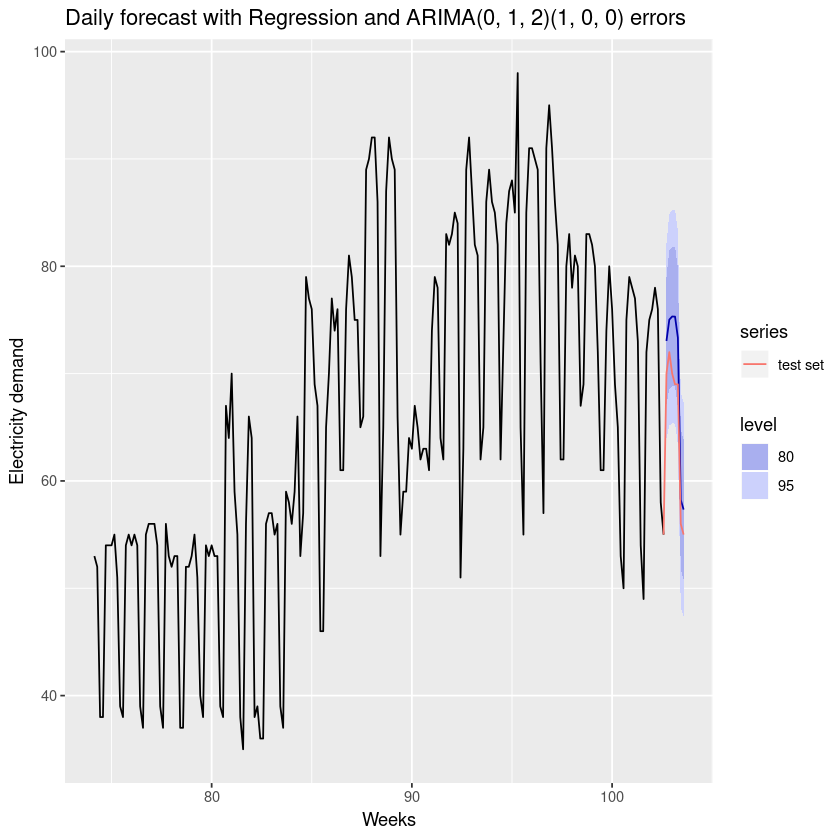

In [83]:
daily.fc.reg <- forecast(daily.fit.reg, xreg=tail(xreg, 7))
autoplot(daily.fc.reg, include = 200) +
    xlab("Weeks") +
    ylab("Electricity demand") +
    autolayer(daily.test, series="test set") +
    ggtitle("Daily forecast with Regression and ARIMA(0, 1, 2)(1, 0, 0) errors")

In [84]:
accuracy(daily.fc.reg, daily.test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.03256952,4.524431,3.029965,-0.6072657,5.476261,0.5090862,-0.003981379,NA
Test set,-3.80114485,4.067844,3.801145,-5.6882644,5.688264,0.6386576,0.410931227,0.7682924


Hourly data has complex seasonality and buildin a regression model can get very difficult, in this case much emphasis has been given to months of the year, days of the week and holidays, that seem to really affect electricity demand. Results are acceptable but previous model gave better results.